
# Modeling COVID-19 with compartmental models

A lot have been heard about the Wuhan disease. This notebook tries to integrate some recently published works on the infectious properties of the disease and models the spread of the disease for educational purposes. The predictions from this work do not take into account explicitly the interventions for reducing the transmission of the virus. 


# WARNING! 
This is not a peer-reviewed work or a work made from an epidemiologist! It is supposed to give some intuition about what to expect from the COVID-19 epidemic with the available data so far. No suitability is expressed or implied for any sort of actual predictions. Other than that, I hope you find this interactive notebook informative and helps you understand some basic epidemiology!

Cheers!

# The SIR model


A simple model of epidemic spread is the so-called SIR model. SIR stands for Susceptible-Infectious-Recovered model. This basic model reads:

\begin{align}
    \frac{dx_S(t)}{dt} & = &-\frac{\beta}{N}& \,x_S(t) x_I(t) &+\quad r_{R\rightarrow S} &\,x_R(t)\\ 
    \frac{dx_I(t)}{dt} & = &\frac{\beta}{N} &\,x_S(t) x_I(t) &- \quad r_{I \rightarrow R} &\,x_I(t) \\
    \frac{dx_R(t)}{dt} & = &r_{I \rightarrow R} &\,x_I(t) &- \quad r_{R\rightarrow S} &\,x_R(t)\\
\end{align}

where 
* $x_S$ is the number of susceptible people, 
* $x_I$ is the number of infected and infectious people (for this model this is the same)
* $\beta$ is a parameter for "infectivity" and 
* $r_{I \rightarrow R}$ is the rate people become immune. 
* $N$ is the population size which satisfies $N = x_R(t) + x_I(t) + x_S(t)$

I drop the population size parameter (N = 1) and consider $x_R, x_I, x_S$ as ratios of the population being in each state.

We assume that the deaths are not so many to change the total population and the people are in a closed community (such as the city of Wuhan). Also the population dynamics related to death and birth are of a much larger scale from the dynamics of the virus spread and recovery so they are separated. After recovery we assume that a percentage of people remain susceptible to infection (based on [this](http://www.cidrap.umn.edu/news-perspective/2020/02/some-covid-19-patients-test-positive-days-after-recovery)). This is modeled with the parameter $r_{R\rightarrow S}$ which models the percentage or people getting re-infected with the disease.
In this model the ratio $R_0 = \frac{\beta}{r_{I \rightarrow R}}$ is called basic reproduction rate. According to  \[1\] we have  $R_0 = 2.68$ which based this estimate on analysis of data from China. This parameter has more to do with the epidemic than the virus, as far as I understand. This makes this parameter a bit counter-intuitive to interpret, if we are considering a closed population in my opinion. The standard interpretation of $R_0$ is *how many people on average are infected from the susceptible population by a single person in the infectious population*.  

The "rate" parameters crucially depend on what I consider "time". A more interpretable scale for time is "days" for the present problem. I add a re-infection parameter that simply models the so-called secondary infections (a part of the population that had the disease before gets it again) or mutation of the virus (this is very common in viruses - one of the reasons that flu cannot be completely eradicated is its fast mutation rate.

\[1\] Wu  JT, Leung  K, Leung  GM.  Nowcasting and forecasting the potential domestic and international spread of the 2019-nCoV outbreak originating in Wuhan, China: a modelling study.  Lancet. Published online January 31, 2020. doi:10.1016/S0140-6736(20)30260-9

In [1]:
from scipy.integrate import odeint
import datetime

import matplotlib.pyplot as pplot
import numpy as np

# Recovery rate in days: current estimate of full recovery time is 14 days
def make_SIRModel_fn(beta,r_ir,r_rs):
    #assert(r_ir+r_rs == 1.)
    def SIR_node(S, time):
        S[S<0] = 0.
        
        xs,xi,xr = S
        
        bxsi = beta*xs*xi
        dx1 = - bxsi  + r_rs * xr # S 
        dx2 = bxsi -r_ir * xi     # I
        dx3 = r_ir*xi - r_rs*xr   # R
        
        return [dx1 , dx2,dx3]
    return SIR_node



## Playing with model parameters:
The infection rate ($\beta$) is the only parameter we can realistically control in a community. This is a function related to human behavior and most probably unpredictable. By informing people on possible containment measures (such as instructing them to wash their hands often, to avoid large gatherings in closed spaces etc) we manage effectively to reduce this rate. You can play around with parameters to see the progression of the disease for different choices of the parameters. 




In [2]:

from ipywidgets import FloatSlider, interact, interactive

def plot_SIR_model_for_parameters(spread_rate , recovery_rate, reinfection_pct,initial_infected, time ):
    sir = make_SIRModel_fn(spread_rate , recovery_rate, reinfection_pct)
    res = odeint(sir,  [1-initial_infected,initial_infected,0.0], np.linspace(0,time,200))
    _fs = 20;
    
    pplot.plot(res)
    pplot.title("Parameters: \n" + r"$ \beta $= %2.3f ,   $r_{I \rightarrow R}$: %2.3f,   $r_{R \rightarrow S}$: %2.3f"%(spread_rate, recovery_rate,reinfection_pct ),fontsize = _fs)
    #pplot.title(r"$\begin{align} \beta = 1.5 , r_{I \rightarrow R}: 0.49, r_{R \rightarrow S}: 0.51 \end{align}")
    pplot.xlabel("time")
    pplot.legend([r"$x_%s$ %s"%(m[1],m) for m in ["(susceptible)", "(infected)","(recovered)"] ], fontsize = _fs)
    pplot.grid()
    pplot.ylim([0,1.])
    
@interact(spread_rate = FloatSlider(min = 1.0, max = 3.5, steps = 100) , recovery_rate = FloatSlider(min = 0.1, max = 5) , reinfection_pct = FloatSlider(min = 0., max = 0.99), initial_infected = FloatSlider(min = 0.01, max =0.50, step = 0.001))
def aa_(spread_rate, recovery_rate, reinfection_pct, initial_infected):
    #spread_rate = 3.5
    pplot.figure(figsize= (10,7.5))
    plot_SIR_model_for_parameters(spread_rate , recovery_rate, reinfection_pct,initial_infected, 100)
    


interactive(children=(FloatSlider(value=1.0, description='spread_rate', max=3.5, min=1.0), FloatSlider(value=0…

## Observations on the SIR model
You can see that in the long term the disease reaches a stable state in the population and this is what I care about (what is going to happen in the long term depending on measures now). I ignore seasonality since this is not proven for this virus yet. The parameters in the following do not have a meaning yet. Later in the notebook I will try and put some reasonable parameters on a better model.

This model gives several intuitions on how infectious diseases progress. Namely,
* The faster the disease spreads the faster the epidemic runs its course
* if the re-infection/mutation rate is low the stable state results in almost no cases of infections

In the following you see the effect on the final state when controlling the infection rate. In practice, since the virus has its own characteristics, we can only control that by trying not to make others sick by self-quarantine or strict hygiene:

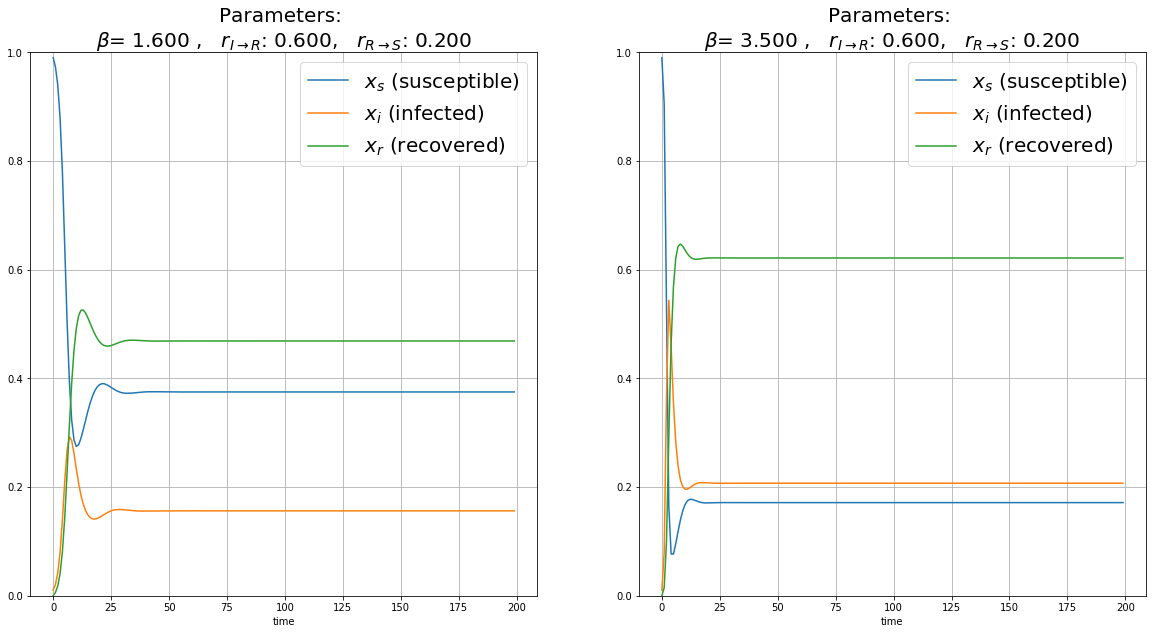

In [3]:
params1 = [1.6,0.60,0.2,0.01,150];
params2 = [3.5,0.60,0.2,0.01,150];

pplot.figure(figsize = (20,10))
pplot.subplot(1,2,1)
plot_SIR_model_for_parameters(*params1)
pplot.subplot(1,2,2)
plot_SIR_model_for_parameters(*params2)



As you can see,  the stable final state of the disease is dependent on how easily it transmits on a population and this makes perfect sense. An interesting thing to observe is that the final percentage of the infected people is not so different though. The plot above has another important lesson: **The susceptible and recovered individuals numbers are very different in the two cases!**. In the first case we get 38\% of the population sick while in the case on the right we get 28% of the population sick. So this means that the people that **never** get the disease are more in the case on the left than in the case on the right and the sustained percentage of the disease is also lower.

This means that a person in the population that can get seriously harmed (or even die) by the disease is much more probable to be **harmed** when we allow the disease to spread freely (according to this model). By being careful with transmission we try to delay the disease to have a situation more like the one on the left. Nevertheless, this model does not tell the whole story...


## Modification of the model to account for delayed disease onset

It is generally believed that diseases spread only after the onset of symptoms (or at least for the most part). The time between the onset of a disease and the onset of transmission is the incubation period of the infection. For COVID-19 this is believed to be 5-6 days but a very conservative estimate states this could be as high as 14 days (this is why a 14 day quarantine is implemented for this virus). In order to model the effect of having *exposed* and not infectious (sick) individuals, we need an additional variable $x_E$. The transition to $x_E$  is only possible from the population of $x_S$ and the transition to $x_I$ in this model is only possible from $x_E$. Note, (in case you are an epidemiologist reading this) that this is not the same modeling strategy as the SEIR or SEIS. I don't model people being removed or added from the population since in the long term this the deaths do not affect the final outcome of the disease.

I consider the people that recover from the infection to be susceptible to the disease again with a certain probability. The parameters as I use them are normalized with time (day) and a "population" of "1". The model variables should be interpreted as *what is the probability of a random person from a closed population to be in each state at day "t"*. Since I need the day-normalized incubation period, the 5 days estimate becomes $r_{E \rightarrow I} = 1/5=0.2$. Note that incubation can be as long as 14 days. This means $r_{E \rightarrow I} = 1/14 = 0.071 $. So the *exposed* people are becoming *infectious* with a rate of 0.2 to 0.071 per day. Having an exposed non-detected population, however, changes the game a little bit. Now there is a lag between transmission. This makes it also a more realistic scenario for the case we want to implement quarantine measures (as it is now happening) and track with this model the effectiveness of such measures.

### Model parameters
For more straight-forward calibration with the available data, I replace $\beta$ with $r_{S \rightarrow E}$. 
In practice this is controlled by the measures taken to limit spread of the virus as in the previous model. This variable, as defined here, depends on several factors including population density, mobility of people, infectivity of the virus, etc. I define,

\begin{align}
r_{S \rightarrow E} = f_s \beta
\end{align}
where 
* $\beta$ is 2.6 (the unnormalized $R_0$)
* $f_s$ a control factor - whether we implement some measure to stop spreading etc.

I like this modeling approach better than the standard models. I think the population normalized calibration of parameters is more intuitive for prediction of outcomes according to current decisions and the current properties of the epidemic. For example in the long-term it is important to know if we can do something to completely eradicate the virus by doing something. It is clear from the SIR model that the best current choice is to delay the virus. This should allow also for better planning in terms of hospital stocks and spaces when/if numbers of cases increase by predicting by how much numbers will increase.

Finally, it should be much easier to include in probabilistic models (however I have to state I'm no epidemiologist).  

\begin{align}
    \frac{dx_S(t)}{dt} & = \quad -r_{S\rightarrow E} \,  & \cdot x_S \cdot x_I &\quad + &\quad r_{R\rightarrow S} \cdot x_R\\ 
    \frac{dx_E(t)}{dt} & = \quad r_{S\rightarrow E} \, & \cdot x_S \cdot x_I  &\quad - &\quad  r_{E \rightarrow I} \cdot x_E\\
    \frac{dx_I(t)}{dt} & = \quad r_{E \rightarrow I} \, &  \cdot x_E     &\quad - &\quad r_{I \rightarrow R} \cdot x_I \\
    \frac{dx_R(t)}{dt} & = \quad r_{I \rightarrow R} \, &  \cdot x_I     &\quad - &\quad r_{R\rightarrow S} \cdot x_R\\
\end{align}

By observing the terms of the corresponding SEIR model of [this](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)30260-9/fulltext) we extract $r_{S \rightarrow E} = R_0/D_I$ where $R_0 = 2.4 \, \text{to} \, 2.8$, is the basic reproduction rate. $D_I  = 5 \, to \, 10$ (called the infectious period - publication gives the estimate 8.4 days.) represents the interval the infected individual is spreading the disease. So the values of $r_{S \rightarrow E}$ may be in the range of **0.24** to **0.56**. I'll use the infectious period estimates from the same publication for estimating $r_{I \rightarrow R} = 1/D_I = 1/8.4$ = 0.11. Furthermore, it is estimated that the incubation period (which is assumed the same as the latent period ) is **5** to **10** days. Therefore $r_{E \rightarrow I} = 1/5 \, \text{to}\, 1/10$ .

In [4]:

# Recovery rate in days: current estimate of full recovery time is 14 days
def make_SEIRModel_fn(rse,rrs,rei, rir):
    #assert(r_ir+r_rs == 1.)
    def SEIR_node(S, time):
        S[S<0] = 0.
        
        xs,xe,xi,xr = S
        rse_xsi = rse*xs*xi
        rei_xe = rei * xe
        rrs_xr = rrs * xr
        rir_xi = rir * xi
        d_xs = - rse_xsi   + rrs_xr
        d_xe = + rse_xsi   - rei_xe
        d_xi = + rei_xe    - rir_xi
        d_xr =   rir_xi    - rrs_xr
        
        return [d_xs , d_xe, d_xi, d_xr]
    return SEIR_node


In [5]:

def plot_SEIR_model_for_parameters(r_se , r_rs, r_ei,r_ir, initial_exposed, idf, time):
    """
    r_se: susceptible to exposed probability
    r_rs: recovered to susceptible. This is probably quite small.
    r_ei: exposed to infectious. That we actually more-or-less know: it's the inverse of the incubation period (5 to 14 days)
    r_ir: 
    """
    
    seir = make_SEIRModel_fn(r_se / idf, r_rs, r_ei, r_ir)
    
    
    
    res = odeint(seir,  [1-initial_exposed,initial_exposed,0.0,0.0], np.linspace(0,time,200))
    total_healthy = res[:,0] + res[:,-1]
    total_sick    = res[:,1] + res[:,2]
    
    _fs = 20;
    
    pplot.plot(res)
    pplot.title("SEIR Parameters: \n" + r"$ r_{S \rightarrow E} $= %2.3f ,   $r_{R \rightarrow S}$: %2.3f , $r_{R \rightarrow S}$: %2.3f, $r_{R \rightarrow S}$: %2.3f"%(r_se , r_rs, r_ei,r_ir)+ "\n"+r"Spread prevention: %2.4f pct, peak $x_I$: %2.4f pct"%((idf-1)*100,np.max(res[:,3])*100 ),fontsize = _fs)
    #pplot.title(r"$\begin{align} \beta = 1.5 , r_{I \rightarrow R}: 0.49, r_{R \rightarrow S}: 0.51 \end{align}")
    pplot.xlabel("days from Wuhan outbreak")
    pplot.legend([r"$x_%s$ %s"%(m[1],m) for m in ["(susceptible)", "(exposed)","(infectious)","(recovered)"] ], fontsize = _fs)
    pplot.grid()
    pplot.ylim([0,1.])
    now_days = (datetime.datetime.today() - datetime.datetime(day = 1, month = 1, year = 2020)).days;
    pplot.axvline(linewidth=1,x = now_days, color='r')
    pplot.text(now_days,0.5,"now", fontsize = 20)
    
    return res, total_healthy, total_sick

@interact(r_se = FloatSlider(min = 0.24, max = 0.56, step = 0.01, value = 0.5),
          r_ir = FloatSlider(min = 0.1, max = 0.2,value = 0.1) ,
          r_rs = FloatSlider(min = 0., max = 1, steps = 100, value = 0.1),
          r_ei = FloatSlider(min = 1/10, max = 1/5,value = 2.1),
          idf  = FloatSlider(min = 1., max = 5.,value = 1.),
          initial_infected = FloatSlider(min = 0.001, max =0.01, step = 0.001))
def aa_(r_se, r_ir, r_rs,r_ei, idf, initial_infected):
    #spread_rate = 3.5
    pplot.figure(figsize= (12,7.5*3))
    pplot.subplot(2,1,1)
    res, h,s = plot_SEIR_model_for_parameters(r_se , r_rs, r_ei,r_ir, initial_infected,idf,100)
    pplot.subplot(2,1,2)
    pplot.plot(h,label = 'total healthy ($x_S+x_R$)')
    pplot.plot(s, label = 'total carriers ($x_E+x_I$)')
    pplot.legend(fontsize = 20)
    pplot.grid()
    pplot.title("total healthy/carriers" , fontsize = 20)
    
    


interactive(children=(FloatSlider(value=0.5, description='r_se', max=0.56, min=0.24, step=0.01), FloatSlider(v…

## Observations
* By implementing spread control measures (the `idf` slider in the interactive chart above) we manage both to reduce the **peak** of the infectious people **and the onset** of the peak. This allows us to prepare better our response mechanisms (hospitals, medicines etc) for the people that are going to get sick. Such measures are the ones everybody talks about: 
  * avoid hand-shakes, use disinfectant
  * avoid large gatherings in closed spaces
  * avoid people with flu-like symptoms
  * avoid traveling to severely affected countries and/or cities - cases are more than the ones detected
  * stay at home 
* There are some parameters that cannot be affected. In what I see the desease is here to stay and it's going to stabilize at infecting at any given moment **constantly** 42.5% of the human population! (This is an anecdotal statement from an epidemiologist. I wouldn't have believed it if I didn't calculate it myself). 
* Vaccination will help reduce the affected people a lot. 
* The secondary infection rate is a big unknown (also in light considering possible vaccinations)


## Bottom line

It goes without saying these results should be taken with a grain of salt to say the least. This is a very crude model of what would happen in an isolated environment and is based on some calibrations of parameters found in the literature. For an isolated community (see **Milan** or **Wuhan**) I think this is a good model of what is going on. A take-home message is that it seems that the epidemic is going to last for some time more because we are delaying it. However, delaying the peak onset of the epidemic by delaying transmission is the best we can do right now! If we don't do that we're going to have a much higher number of deaths. 

## Important note

This work neglects the important measures taken to prevent this disease from spreading in severely affected areas.